In [21]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle

In [2]:
processor = AutoProcessor.from_pretrained("./SmolVLM-256M-Detection/")

In [3]:
im = Image.open('pets.jpg').convert('RGB')

In [24]:
example = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "detect dog"}
        ]
    }
]

In [25]:
text = processor.apply_chat_template(example,tokenize=False,add_generation_prompt=True)
text

'<|im_start|>User:<image>detect dog<end_of_utterance>\nAssistant:'

In [26]:
inputs = processor(
        text=text, 
        images=im, 
        return_tensors='pt',
        size={'longest_edge': 512},
        padding=True
    ).to('cuda')

In [9]:
model = AutoModelForVision2Seq.from_pretrained(
    "./SmolVLM-256M-Detection/",
    torch_dtype=torch.bfloat16,
).to('cuda')

In [10]:
model.eval()

Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
        (position_embedding): Embedding(1024, 768)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-11): 12 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_features=7

In [38]:
# Generate output
with torch.no_grad():
    output_ids = model.generate(**inputs, max_new_tokens=128)

output_text = processor.tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(output_text)

User:detect dog
Assistant: dog <loc040><loc113><loc255><loc240>;


In [12]:
import re

In [17]:
def tokens_to_bbox(tokens,img_width,img_height,num_tokens=256):
    """
    token[y_min, x_min, y_max, x_max] -> (x,y,w,h)
    """
    y_min, x_min, y_max, x_max = [int(re.search(r"\d+", t).group()) for t in tokens]

    assert not any(v>num_tokens-1 or v<0 for v in [y_min, x_min, y_max, x_max]), f'incorrect tokens: {tokens}'

    x_min = (x_min / (num_tokens-1)) * img_width
    y_min = (y_min / (num_tokens-1)) * img_height
    x_max = (x_max / (num_tokens-1)) * img_width
    y_max = (y_max / (num_tokens-1)) * img_height

    bbox = [round(x_min,2), round(y_min,2), round(x_max-x_min, 2), round(y_max-y_min,2)]
    return bbox

In [19]:
tokens = '<loc050>,<loc079>,<loc249>,<loc231>'.split(',')
bbox = tokens_to_bbox(tokens,512,512)
bbox

[158.62, 100.39, 305.19, 399.56]

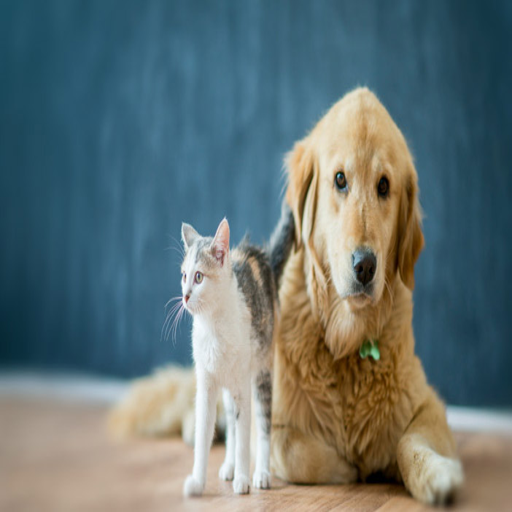

In [20]:
im = im.resize((512,512))

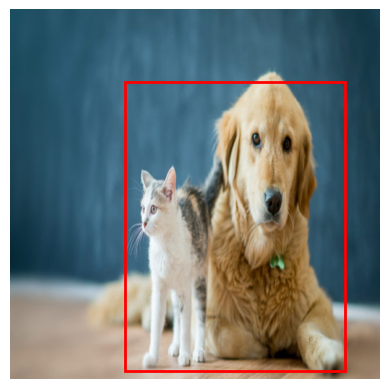

In [23]:
fig, ax = plt.subplots()
ax.imshow(im)
rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                         linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)
ax.axis('off')
plt.show()

In [28]:
tokens2='<loc040>,<loc113>,<loc255,><loc240>'.split(',')
bbox2=tokens_to_bbox(tokens2,512,512)

In [29]:
bbox2

[226.89, 80.31, 255.0, 431.69]

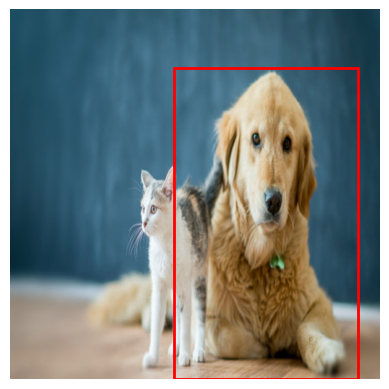

In [30]:
fig, ax = plt.subplots()
ax.imshow(im)
rect = Rectangle((bbox2[0], bbox2[1]), bbox2[2], bbox2[3],
                         linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)
ax.axis('off')
plt.show()

In [34]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [36]:
!wget -O person_car.jpg https://freerangestock.com/sample/39777/a-person-jumps-over-a-car.jpg

--2025-05-17 12:48:36--  https://freerangestock.com/sample/39777/a-person-jumps-over-a-car.jpg
104.25.56.65, 172.67.65.237, 104.25.55.65, ...om)... 
connected. to freerangestock.com (freerangestock.com)|104.25.56.65|:443... 
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘person_car.jpg’

person_car.jpg          [ <=>                ]  94.43K  --.-KB/s    in 0.03s   

2025-05-17 12:48:41 (2.80 MB/s) - ‘person_car.jpg’ saved [96695]



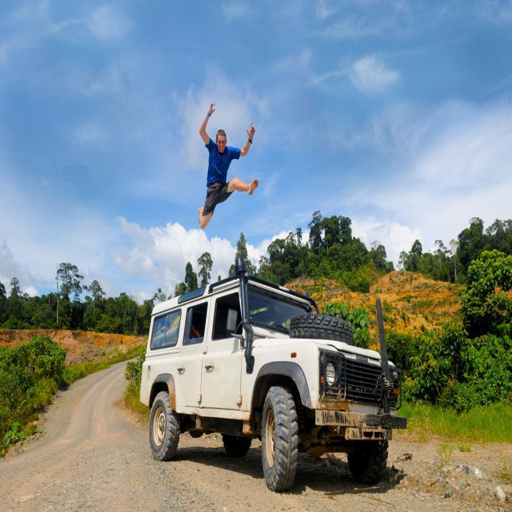

In [37]:
im2 = Image.open('person_car.jpg').convert('RGB').resize((512,512))
im2

In [73]:
def predict(input_text,im):
    example = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": input_text}
            ]
        }
    ]
    text = processor.apply_chat_template(example,tokenize=False,add_generation_prompt=True)
    inputs = processor(
        text=text, 
        images=im, 
        return_tensors='pt',
        size={'longest_edge': 512},
        padding=True
    ).to('cuda')
    
    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=128)
    
    output_text = processor.tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(output_text)
    
    pattern = r"\w+\s[<loc\d+>]+;"
    matches = re.findall(pattern, output_text)

    results = []
    if len(matches) > 0:
        for match in matches:
            category,tokens = match.split(' ')
            tokens = re.findall(r"<loc\d+>",tokens)
            bbox = tokens_to_bbox(tokens, 512, 512)
            results.append((category, bbox))
    return results

In [79]:
results = predict('detect car',im2)
results

User:detect car
Assistant: car <loc122><loc078><loc248><loc209>;


[('car', [156.61, 244.96, 263.03, 252.99])]

In [80]:
def show_detections(image: Image.Image,
                    detections: list[tuple[str, list[float]]],
                    box_color: str = 'lime',
                    text_color: str = 'white',
                    linewidth: int = 2,
                    fontsize: int = 10):

    fig, ax = plt.subplots()
    ax.imshow(image)

    for label, (x, y, w, h) in detections:
        rect = Rectangle((x, y), w, h,
                                 linewidth=linewidth,
                                 edgecolor=box_color,
                                 facecolor='none')
        ax.add_patch(rect)

        txt = ax.text(x, y - 4, label,
                      va='bottom', ha='left',
                      fontsize=fontsize,
                      color=text_color,
                      bbox=dict(boxstyle='round,pad=0.15',
                                fc=box_color, ec='none', alpha=0.7))

    ax.axis('off')
    plt.tight_layout()
    plt.show()

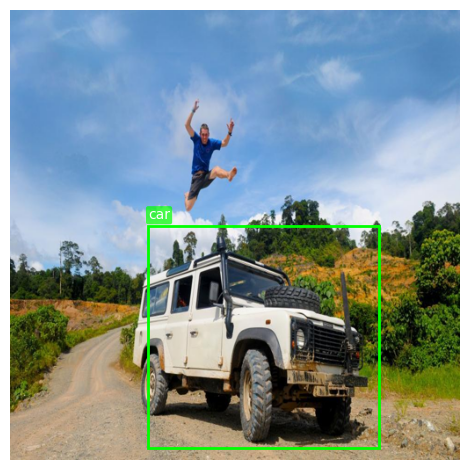

In [81]:
show_detections(im2, results)

In [83]:
!wget -O pedestrian.jpg "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQVvGo0DRMDa-Vq6-W03OCXWH99W1V-hgKa2g&s"

--2025-05-17 13:13:18--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQVvGo0DRMDa-Vq6-W03OCXWH99W1V-hgKa2g&s
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 142.250.67.238, 2404:6800:4009:82f::200e
connected. to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|142.250.67.238|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 10373 (10K) [image/jpeg]
Saving to: ‘pedestrian.jpg’

pedestrian.jpg      100%[===================>]  10.13K  --.-KB/s    in 0.004s  

2025-05-17 13:13:18 (2.46 MB/s) - ‘pedestrian.jpg’ saved [10373/10373]



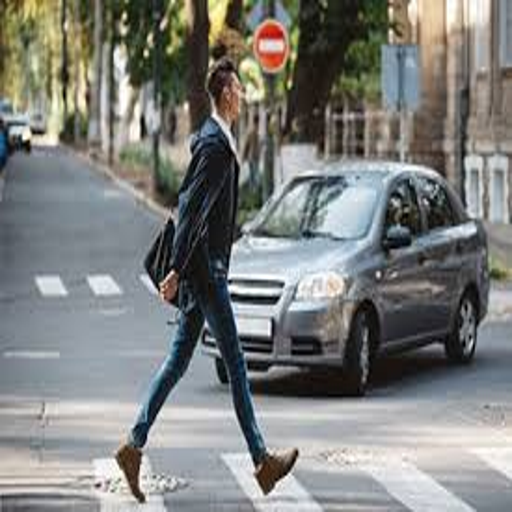

In [85]:
im3 = Image.open('pedestrian.jpg').convert('RGB').resize((512,512))
im3

User:detect person
Assistant: person <loc021><loc059><loc255><loc140>;


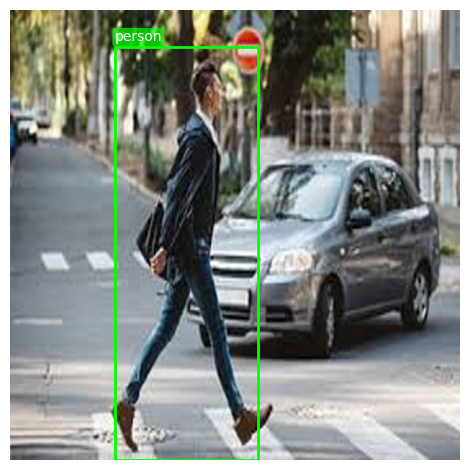

In [87]:
results = predict('detect person',im3)
show_detections(im3,results)

User:detect car
Assistant: car <loc066><loc104><loc199><loc241>;


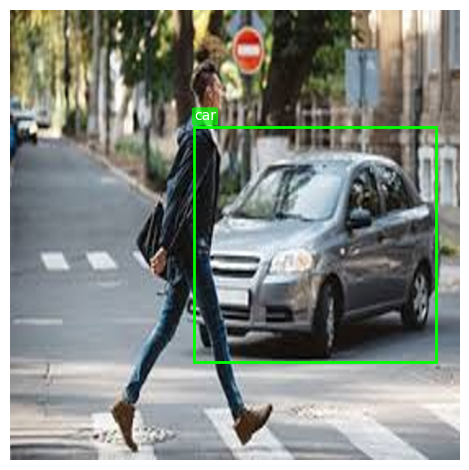

In [88]:
results = predict('detect car',im3)
show_detections(im3,results)

User:detect car; person
Assistant: car <loc066><loc103><loc189><loc234>;
person <loc021><loc059><loc255><loc160>;


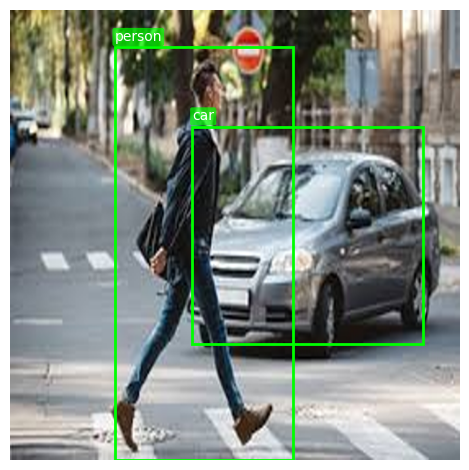

In [90]:
results = predict('detect car; person',im3)
show_detections(im3,results)